# **Especialização em Deep Learning - UFPE**
**Disciplina:** Processamento de Linguagem Natural com Deep Learning

**Professor:** Luciano Barbosa

**Projeto:** Coletar avaliações de um produto selecionado no site da Amazon e treinar classificadores.

**Equipe:**

*   Andrey Rodrigues de Freitas
*   Reginaldo Cunha


## **Importações**

In [2]:
# Importar as bibliotecas
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import json

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import LlamaTokenizer, LlamaForCausalLM
from transformers import pipeline
from transformers import TrainerCallback

from warnings import filterwarnings
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
import re

from textblob import TextBlob
from wordcloud import WordCloud
import cufflinks as cf
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.max_columns', None)

In [3]:
# Carregar o dataset
df = pd.read_csv("/Users/reginaldocunha/Documents/Especialização em Deep Learning/NLP/amazon_reviews.csv")

## **Exploração dos dados**

A base de dados amazon_reviews.csv possui um conjunto de avaliações de produtos da Amazon. Segue detalhamento dos campos:

*   **Unnamed**: 0: Índice.
*   **reviewerName**: Nome do revisor.
*   **overall**: A nota geral da avaliação.
*   **reviewText**: O texto completo da avaliação.
*   **reviewTime**: Data da avaliação, em formato de string.
*   **day_diff**: Diferença em dias entre a data da avaliação e uma data de referência.
*   **helpful_yes**: Número de votos "útil" positivos.
*   **helpful_no**: Número de votos "útil" negativos.
*   **total_vote**: Número total de votos recebidos pela avaliação.
*   **score_pos_neg_diff**: Diferença entre o número de votos positivos e negativos (útil para medir a polaridade da avaliação).
*   **score_average_rating**: A média das avaliações atribuídas ao produto.
*   **wilson_lower_bound**: Uma métrica estatística que pode ser usada para calcular a estimativa do intervalo de confiança para a proporção de votos "útil" positivos.

In [4]:
# Visualizar o 10 primeiros registros do dataset
df.drop('Unnamed: 0', inplace = True, axis = 1)
df.head(10)

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.000000
1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.000000
2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.000000
3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.000000
4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.000000
5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.000000
6,2K1Toaster,5.0,I have it in my phone and it never skips a bea...,2013-10-19,415,0,0,0,0,0.0,0.000000
7,"35-year Technology Consumer ""8-tracks to 802.11""",5.0,It's hard to believe how affordable digital ha...,2014-10-07,62,0,0,0,0,0.0,0.000000
8,4evryoung,5.0,Works in a HTC Rezound. Was running short of ...,2014-03-24,259,1,0,1,1,1.0,0.206549
9,53rdcard,5.0,"in my galaxy s4, super fast card, and am total...",2013-11-10,393,0,0,0,0,0.0,0.000000


In [5]:
# Verificar informações gerais sobre o dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewerName          4914 non-null   object 
 1   overall               4915 non-null   float64
 2   reviewText            4914 non-null   object 
 3   reviewTime            4915 non-null   object 
 4   day_diff              4915 non-null   int64  
 5   helpful_yes           4915 non-null   int64  
 6   helpful_no            4915 non-null   int64  
 7   total_vote            4915 non-null   int64  
 8   score_pos_neg_diff    4915 non-null   int64  
 9   score_average_rating  4915 non-null   float64
 10  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(5), object(3)
memory usage: 422.5+ KB
None


In [6]:
def check_class(dataframe):
    nunique_df = pd.DataFrame({'Variable': dataframe.columns,
                               'Classes': [dataframe[i].nunique() \
                                           for i in dataframe.columns]})

    nunique_df = nunique_df.sort_values('Classes', ascending=False)
    nunique_df = nunique_df.reset_index(drop = True)
    return nunique_df

check_class(df)

,Variable,Classes
0,reviewText,4912
1,reviewerName,4594
2,reviewTime,690
3,day_diff,690
4,wilson_lower_bound,40
5,score_average_rating,28
6,score_pos_neg_diff,27
7,total_vote,26
8,helpful_yes,23
9,helpful_no,17


In [7]:
# Estatísticas descritivas para as colunas numéricas
print(df.describe())

           overall     day_diff  helpful_yes   helpful_no   total_vote  \
count  4915.000000  4915.000000  4915.000000  4915.000000  4915.000000   
mean      4.587589   437.367040     1.311089     0.210376     1.521465   
std       0.996845   209.439871    41.619161     4.023296    44.123095   
min       1.000000     1.000000     0.000000     0.000000     0.000000   
25%       5.000000   281.000000     0.000000     0.000000     0.000000   
50%       5.000000   431.000000     0.000000     0.000000     0.000000   
75%       5.000000   601.000000     0.000000     0.000000     0.000000   
max       5.000000  1064.000000  1952.000000   183.000000  2020.000000   

       score_pos_neg_diff  score_average_rating  wilson_lower_bound  
count         4915.000000           4915.000000         4915.000000  
mean             1.100712              0.075468            0.020053  
std             39.367949              0.256062            0.077187  
min           -130.000000              0.000000      

**Text Visualization**

In [8]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/reginaldocunha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/reginaldocunha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/reginaldocunha/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
def text_preprocessing(dataframe, dependent_var):
  # Normalizing Case Folding - Uppercase to Lowercase
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

  # Removing Punctuation
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')

  # Removing Numbers
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')

  # StopWords
  sw = stopwords.words('english')
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

  # Remove Rare Words
  temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

  # Lemmatize
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  return dataframe

In [10]:
df = text_preprocessing(df, "reviewText")
df["reviewText"].head()

0                                              issues.
1    purchased device, worked advertised. never muc...
2    work expected. higher capacity. think made bit...
3    think worked 64gb card went south 3 one held p...
4    bought retail packaging, arrived legit, versio...
Name: reviewText, dtype: object

In [11]:
def text_visulaization(dataframe, dependent_var, barplot=True, wordcloud=True):
  # Calculation of Term Frequencies
  tf = dataframe[dependent_var].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
  tf.columns = ["words", "tf"]

  if barplot:
    # Bar Plot
    tf[tf["tf"]>1000].plot.barh(x="words", y="tf")
    plt.title("Calculation of Term Frequencies : barplot")
    plt.show()

  if wordcloud:
    # WordCloud
    text = " ".join(i for i in dataframe[dependent_var])
    wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(text)
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Calculation of Term Frequencies : wordcloud")
    plt.show()
    wordcloud.to_file("wordcloud.png")

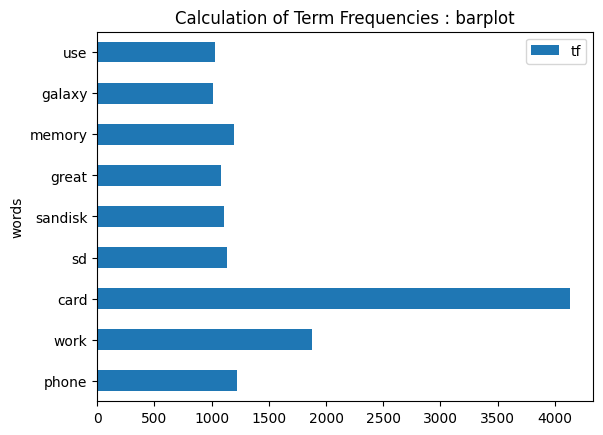

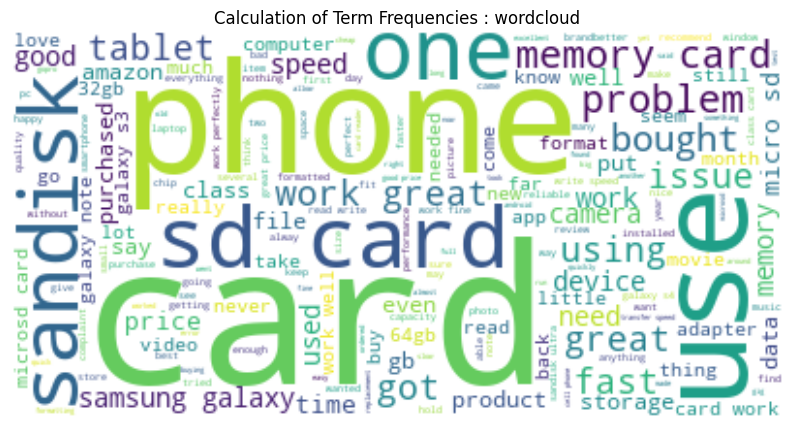

In [12]:
text_visulaization(df, "reviewText")

**Análise da Nota Média vs. Votos Úteis**

Analisar como a média das notas (overall) se relaciona com a quantidade de votos úteis (helpful_yes e helpful_no).

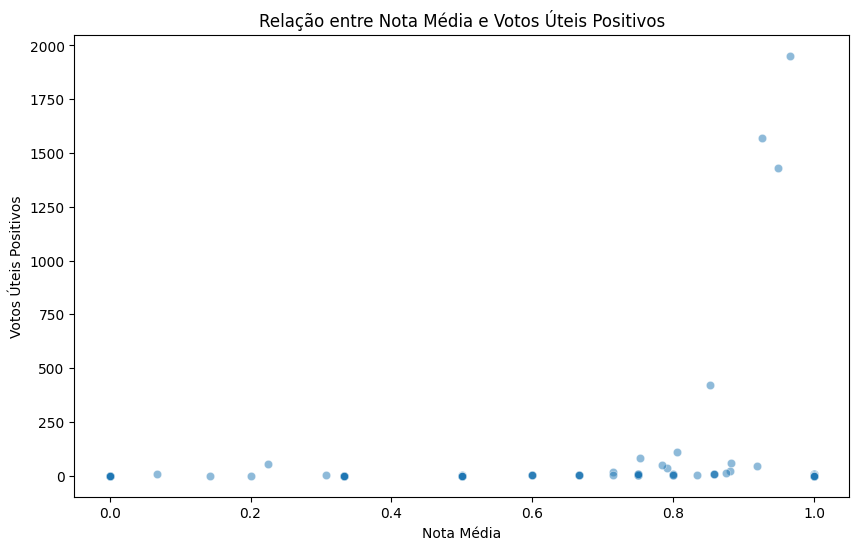

In [13]:
# Plotando a correlação entre nota média e votos úteis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='score_average_rating', y='helpful_yes', data=df, alpha=0.5)
plt.title('Relação entre Nota Média e Votos Úteis Positivos')
plt.xlabel('Nota Média')
plt.ylabel('Votos Úteis Positivos')
plt.show()

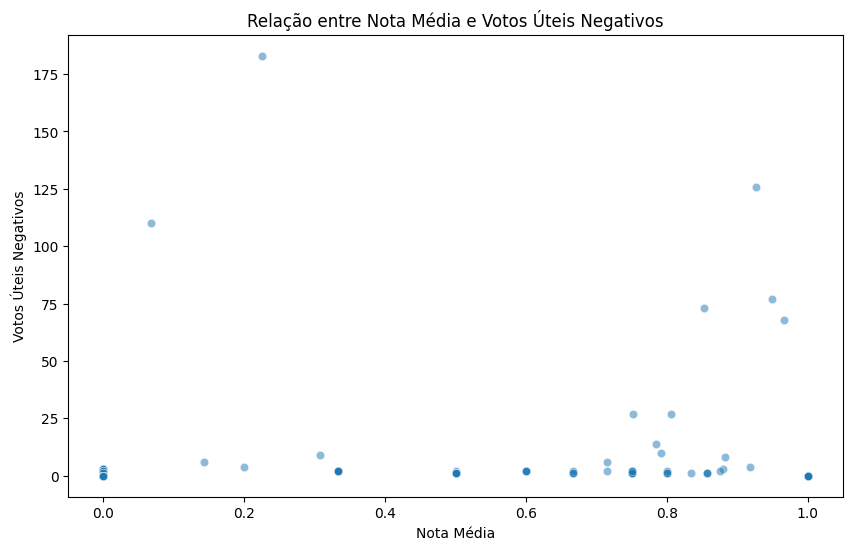

In [14]:
# Analisando a relação com os votos negativos
plt.figure(figsize=(10, 6))
sns.scatterplot(x='score_average_rating', y='helpful_no', data=df, alpha=0.5)
plt.title('Relação entre Nota Média e Votos Úteis Negativos')
plt.xlabel('Nota Média')
plt.ylabel('Votos Úteis Negativos')
plt.show()

**Análise da Distribuição de Votos**

Analisar a distribuição das notas (overall) ajuda a entender como as avaliações estão distribuídas.

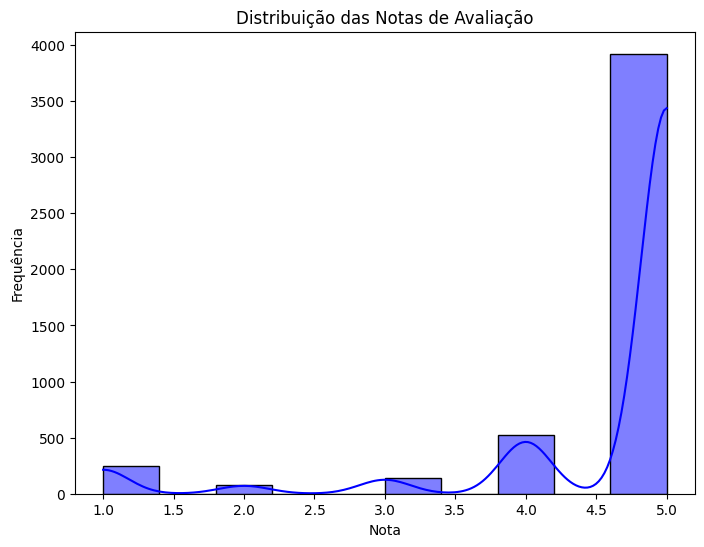

In [15]:
# Plotando a distribuição das notas
plt.figure(figsize=(8, 6))
sns.histplot(df['overall'], kde=True, bins=10, color='blue')
plt.title('Distribuição das Notas de Avaliação')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.show()

In [16]:
# Analise da variavel 'overall'

constraints = ['#581845','#C70039','#2E4053','#1ABC9C','#7F8C8D']

def categorical_variable_summary(df, column_name):
    fig = make_subplots(rows=1,cols=2,
                        subplot_titles=('Countplot','Percentages'),
                        specs=[[{"type": "xy"}, {'type':'domain'}]])

    fig.add_trace(go.Bar( y = df[column_name].value_counts().values.tolist(), 
                          x = [str(i) for i in df[column_name].value_counts().index], 
                          text = df[column_name].value_counts().values.tolist(),
                          textfont = dict(size=15),
                          name = column_name,
                          textposition = 'auto',
                          showlegend=False,
                          marker=dict(color = constraints,
                                      line=dict(color='#DBE6EC',
                                                width=1))),
                  row = 1, col = 1)
    
    fig.add_trace(go.Pie(labels= df[column_name].value_counts().keys(),
                         values= df[column_name].value_counts().values,
                         textfont = dict(size = 20),
                         textposition='auto',
                         showlegend = False,
                         name = column_name,
                         marker=dict(colors=constraints)),
                  row = 1, col = 2)
    
    fig.update_layout(title={'text': column_name,
                             'y':0.9,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    
    iplot(fig)

categorical_variable_summary(df,'overall')

**Análise da Diferença de Votos Positivos e Negativos**

Explorar a diferença entre votos positivos e negativos (score_pos_neg_diff), verificando se há alguma tendência interessante.

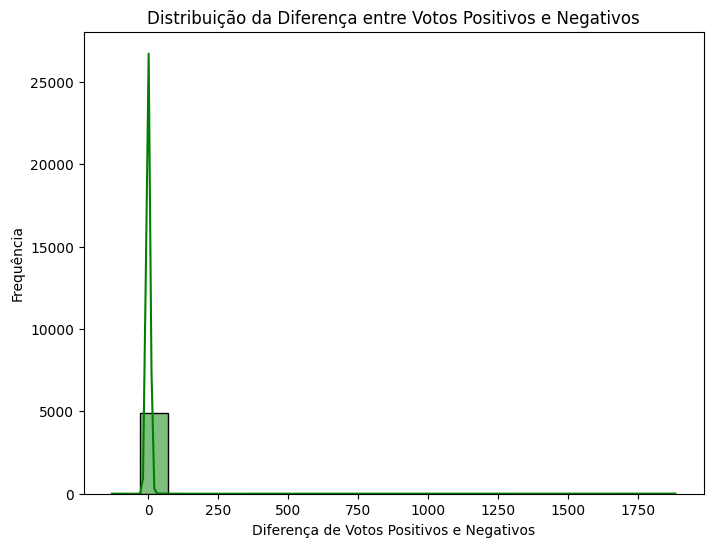

In [17]:
# Plotando a distribuição da diferença entre votos positivos e negativos
plt.figure(figsize=(8, 6))
sns.histplot(df['score_pos_neg_diff'], kde=True, color='green', bins=20)
plt.title('Distribuição da Diferença entre Votos Positivos e Negativos')
plt.xlabel('Diferença de Votos Positivos e Negativos')
plt.ylabel('Frequência')
plt.show()

**Análise de Votos e Relevância de Avaliações**

Analisar se o número de votos úteis (total_vote) influencia a relevância ou qualidade das avaliações.

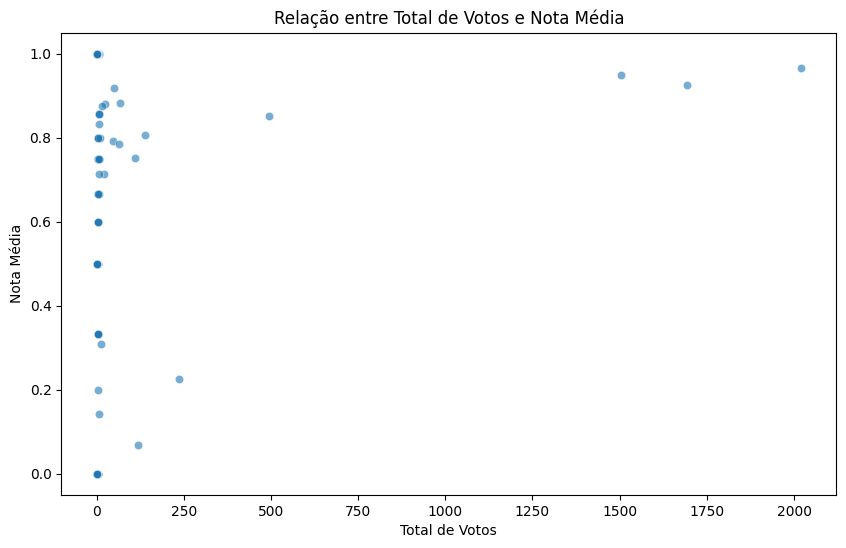

In [18]:
# Relacionando total de votos com a nota média
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_vote', y='score_average_rating', data=df, alpha=0.6)
plt.title('Relação entre Total de Votos e Nota Média')
plt.xlabel('Total de Votos')
plt.ylabel('Nota Média')
plt.show()

## **Análise de Sentimentos**

**Análise de Sentimentos no Texto das Avaliações**

Análise simples de sentimentos usando a biblioteca TextBlob para as avaliações textuais.

                                          reviewText  sentiment
0                                            issues.       0.00
1  purchased device, worked advertised. never muc...      -0.10
2  work expected. higher capacity. think made bit...       0.13
3  think worked 64gb card went south 3 one held p...       0.25
4  bought retail packaging, arrived legit, versio...       0.48


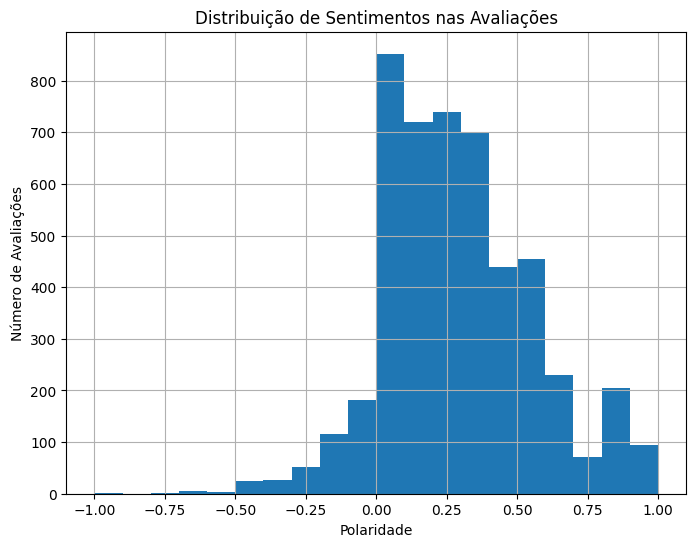

In [19]:
from textblob import TextBlob

# Função para determinar o sentimento
def analyze_sentiment(text):
    blob = TextBlob(text)
    # Retorna polaridade (positiva ou negativa)
    return blob.sentiment.polarity

# Aplicando a função ao dataframe
df['sentiment'] = df['reviewText'].apply(lambda x: analyze_sentiment(str(x)))

# Exibindo as primeiras linhas com a análise de sentimento
print(df[['reviewText', 'sentiment']].head())

# Distribuição de sentimentos
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
df['sentiment'].hist(bins=20)
plt.title('Distribuição de Sentimentos nas Avaliações')
plt.xlabel('Polaridade')
plt.ylabel('Número de Avaliações')
plt.show()


**Relação Entre Tempo de Avaliação e Sentimento**

Examinar se existe uma relação entre o tempo da avaliação (reviewTime) e o sentimento das avaliações.

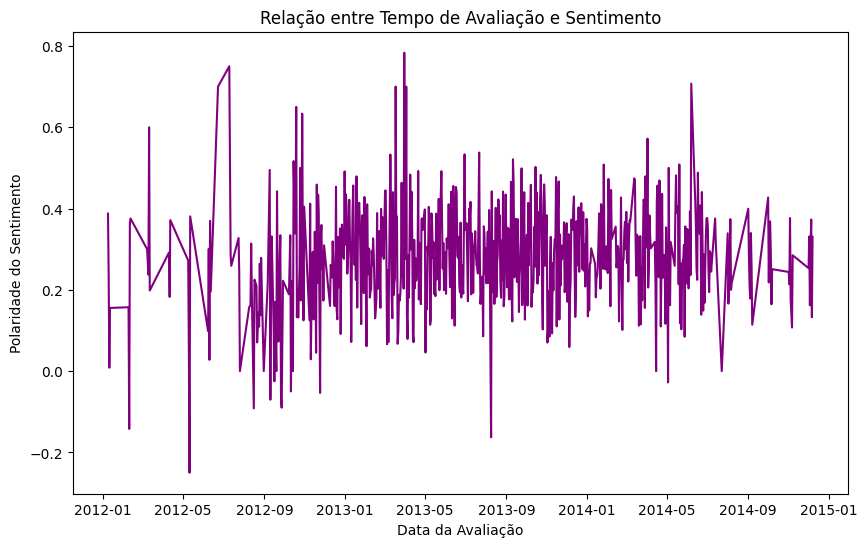

In [20]:
# Convertendo reviewTime para datetime
df['reviewTime'] = pd.to_datetime(df['reviewTime'], errors='coerce')

# Plotando a relação entre o tempo de avaliação e a polaridade do sentimento
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['reviewTime'], y=df['sentiment'], ci=None, color='purple')
plt.title('Relação entre Tempo de Avaliação e Sentimento')
plt.xlabel('Data da Avaliação')
plt.ylabel('Polaridade do Sentimento')
plt.show()

In [21]:
# Análise de sentimento
# TextBlob Exit retornará polaridade e subjetividade.
# Polaridade indica seu humor, ou seja, se ele é positivo.
# Ele retorna um valor entre 0 e 1. Quanto mais próximo de 1, mais positivo, quanto mais próximo de 0, mais negativo.

df[['polarity', 'subjectivity']] = df['reviewText'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for i, row in enumerate(df['reviewText']):

    score = SentimentIntensityAnalyzer().polarity_scores(row)

    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    if neg > pos:
        df.loc[i, 'sentiment'] = "Negative"
    elif pos > neg:
        df.loc[i, 'sentiment'] = "Positive"
    else:
        df.loc[i, 'sentiment'] = "neutral"

# Balanceamento dos dados
categorical_variable_summary(df,'sentiment')

In [22]:
# Balanceamento dos scores
df.groupby(["sentiment"])[['overall']].mean()

,overall
sentiment,
Negative,3.83
Positive,4.70
neutral,4.64


**Análise da Coluna ReviewText**

In [23]:
# Visualização da coluna de Review
df.reviewText.head()

0                                              issues.
1    purchased device, worked advertised. never muc...
2    work expected. higher capacity. think made bit...
3    think worked 64gb card went south 3 one held p...
4    bought retail packaging, arrived legit, versio...
Name: reviewText, dtype: object

In [24]:
# Selecionar somente as colunas reviewText e Overall para análise
data = df[['reviewText', 'overall']].dropna()

In [25]:
data

,reviewText,overall
0,issues.,4.00
1,"purchased device, worked advertised. never muc...",5.00
2,work expected. higher capacity. think made bit...,4.00
3,think worked 64gb card went south 3 one held p...,5.00
4,"bought retail packaging, arrived legit, versio...",5.00
...,...,...
4910,"bought sandisk 16gb class 10 use htc 3 months,...",1.00
4911,used capability samsung galaxy note 10. greatl...,5.00
4912,great card fast reliable. come optional adapte...,5.00
4913,"good amount space stuff want do, fit gopro. say?",5.00


In [26]:
# Converter notas para sentimento binário (1 = positivo, 0 = negativo)
data['label'] = data['overall'].apply(lambda x: 1 if x >= 4 else 0)

In [27]:
data

,reviewText,overall,label
0,issues.,4.00,1
1,"purchased device, worked advertised. never muc...",5.00,1
2,work expected. higher capacity. think made bit...,4.00,1
3,think worked 64gb card went south 3 one held p...,5.00,1
4,"bought retail packaging, arrived legit, versio...",5.00,1
...,...,...,...
4910,"bought sandisk 16gb class 10 use htc 3 months,...",1.00,0
4911,used capability samsung galaxy note 10. greatl...,5.00,1
4912,great card fast reliable. come optional adapte...,5.00,1
4913,"good amount space stuff want do, fit gopro. say?",5.00,1


**Separar os dados entre Treino e Teste**

In [28]:
# Dividir dados em treino e teste
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['reviewText'], data['label'], test_size=0.2, random_state=42)

## **SVM + Bag of Words (BoW)**

Neste primeiro exemplo, vamos usar o SVM com Bag of Words para a classificação de sentimentos a partir do texto das avaliações.

In [29]:
# Vetorização Bag of Words
vectorizer_bow = CountVectorizer(stop_words='english')
X_train_bow = vectorizer_bow.fit_transform(train_texts)
X_test_bow = vectorizer_bow.transform(test_texts)

# Treinamento SVM
svm_bow = SVC(kernel='linear')
svm_bow.fit(X_train_bow, train_labels)

# Previsão e Avaliação
pred_bow = svm_bow.predict(X_test_bow)
acc_bow = accuracy_score(test_labels, pred_bow)
f1_bow = f1_score(test_labels, pred_bow)

print(f"SVM + BoW - Acurácia: {acc_bow:.2f}, F1-Score: {f1_bow:.2f}")

SVM + BoW - Acurácia: 0.92, F1-Score: 0.96


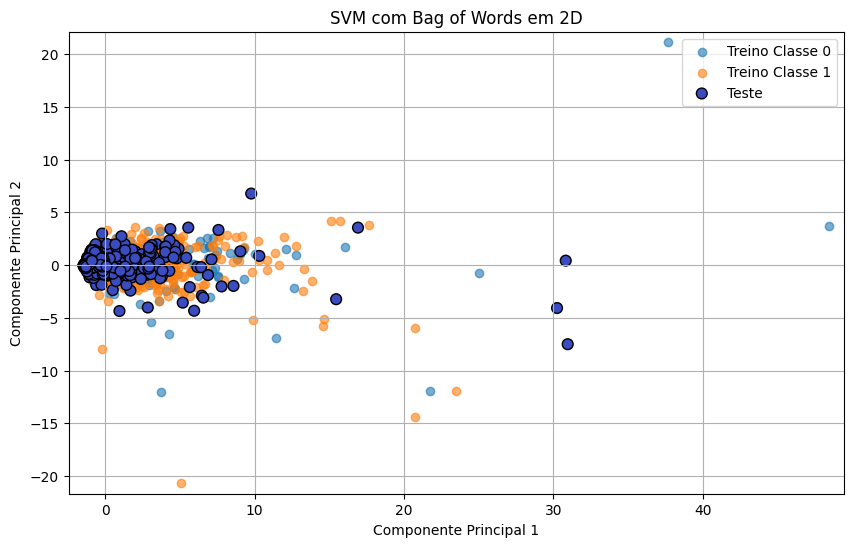

In [30]:
# Redução de dimensionalidade com PCA para visualização em 2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_bow.toarray())
X_test_2d = pca.transform(X_test_bow.toarray())

# Treinar o modelo novamente com dados reduzidos
svm_bow_2d = SVC(kernel='linear', probability=True)
svm_bow_2d.fit(X_train_2d, train_labels)

# Predições com dados de teste reduzidos
pred_2d = svm_bow_2d.predict(X_test_2d)

# Gráfico de dispersão com separador de decisão
plt.figure(figsize=(10, 6))

# Plotar os pontos de treino por classe
for label in np.unique(train_labels):
    plt.scatter(X_train_2d[train_labels == label, 0], 
                X_train_2d[train_labels == label, 1], 
                label=f'Treino Classe {label}', alpha=0.6)

# Gerar o grid para a linha de decisão
xx, yy = np.meshgrid(np.linspace(X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1, 500),
                     np.linspace(X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1, 500))

Z = svm_bow_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotar a linha de decisão
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red', linestyles='--')

# Configurações finais do gráfico
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=pred_2d, cmap='coolwarm', label='Teste', edgecolors='k', s=60)
plt.title('SVM com Bag of Words em 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()


## **SVM + Embeddings (TF-IDF)**

In [31]:
# Vetorização com TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer_tfidf.fit_transform(train_texts)
X_test_tfidf = vectorizer_tfidf.transform(test_texts)

# Treinamento SVM
svm_tfidf = SVC()
svm_tfidf.fit(X_train_tfidf, train_labels)

# Avaliação
pred_tfidf = svm_tfidf.predict(X_test_tfidf)
acc_tfidf = accuracy_score(test_labels, pred_tfidf)
f1_tfidf = f1_score(test_labels, pred_tfidf)

print(f"SVM + TF-IDF - Acurácia: {acc_tfidf:.2f}, F1-Score: {f1_tfidf:.2f}")

SVM + TF-IDF - Acurácia: 0.93, F1-Score: 0.96


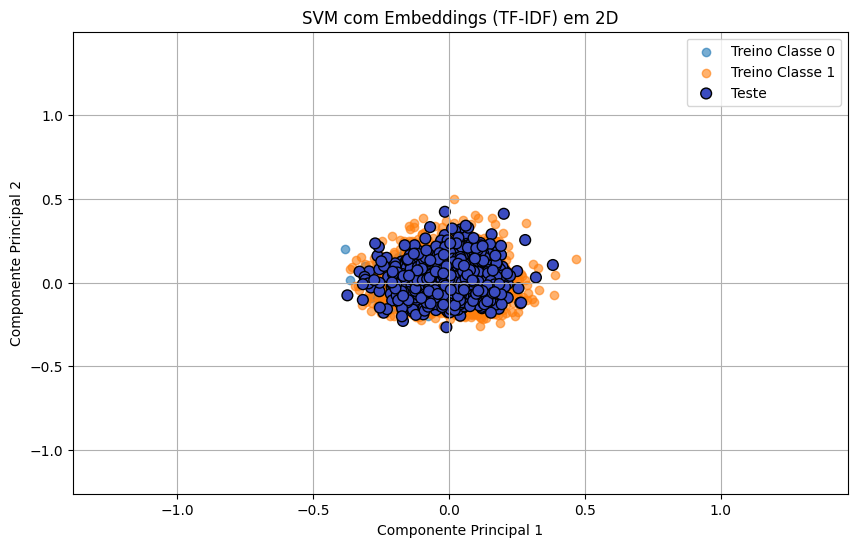

In [32]:
# Redução de dimensionalidade para visualização em 2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_tfidf.toarray())
X_test_2d = pca.transform(X_test_tfidf.toarray())

# Treinar o modelo novamente com dados reduzidos
svm_tfidf_2d = SVC(kernel='linear', probability=True)
svm_tfidf_2d.fit(X_train_2d, train_labels)

# Predições com dados de teste reduzidos
pred_2d = svm_tfidf_2d.predict(X_test_2d)

# Gráfico de dispersão com separador de decisão
plt.figure(figsize=(10, 6))

# Plotar os pontos de treino por classe
for label in np.unique(train_labels):
    plt.scatter(X_train_2d[np.array(train_labels) == label, 0], 
                X_train_2d[np.array(train_labels) == label, 1], 
                label=f'Treino Classe {label}', alpha=0.6)

# Gerar o grid para a linha de decisão
xx, yy = np.meshgrid(np.linspace(X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1, 500),
                     np.linspace(X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1, 500))

Z = svm_tfidf_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotar a linha de decisão
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red', linestyles='--')

# Configurações finais do gráfico
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=pred_2d, cmap='coolwarm', label='Teste', edgecolors='k', s=60)
plt.title('SVM com Embeddings (TF-IDF) em 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()


## **BERT com Fine-Tuning**

In [33]:
# Desativar o wandb
os.environ["WANDB_DISABLED"] = "true"

# Configuração do modelo BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Tokenização
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# Dataset para o Trainer
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewsDataset(train_encodings, train_labels.tolist())
test_dataset = ReviewsDataset(test_encodings, test_labels.tolist())

# Definir função de métricas
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1
    }

# Definir parâmetros de treinamento
training_args = TrainingArguments(
    output_dir="./results",             # output directory
    num_train_epochs=3,                 # number of training epochs
    per_device_train_batch_size=8,      # batch size for training
    per_device_eval_batch_size=16,      # batch size for evaluation
    warmup_steps=500,                   # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                  # strength of weight decay
    evaluation_strategy="epoch",
    logging_dir="./logs",             # directory for storing logs
)

# Treinamento com Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # Função de métricas
)

# Treinamento e Avaliação
trainer.train()
results = trainer.evaluate()

print(f"BERT - Acurácia: {results['eval_accuracy']:.4f}, F1 Score: {results['eval_f1']:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  0%|          | 0/1476 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.3162788450717926, 'eval_accuracy': 0.9033570701932858, 'eval_f1': 0.9492250133618386, 'eval_runtime': 7.9704, 'eval_samples_per_second': 123.332, 'eval_steps_per_second': 7.779, 'epoch': 1.0}
{'loss': 0.2979, 'grad_norm': 4.374055862426758, 'learning_rate': 5e-05, 'epoch': 1.02}


  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.16535747051239014, 'eval_accuracy': 0.9338758901322483, 'eval_f1': 0.9628783552255854, 'eval_runtime': 7.5233, 'eval_samples_per_second': 130.661, 'eval_steps_per_second': 8.241, 'epoch': 2.0}
{'loss': 0.2461, 'grad_norm': 0.8215640783309937, 'learning_rate': 2.4385245901639343e-05, 'epoch': 2.03}


  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.24604476988315582, 'eval_accuracy': 0.9379450661241099, 'eval_f1': 0.9665019220208677, 'eval_runtime': 7.3692, 'eval_samples_per_second': 133.392, 'eval_steps_per_second': 8.413, 'epoch': 3.0}
{'train_runtime': 384.9772, 'train_samples_per_second': 30.641, 'train_steps_per_second': 3.834, 'train_loss': 0.23644170270056583, 'epoch': 3.0}


  0%|          | 0/62 [00:00<?, ?it/s]

BERT - Acurácia: 0.9379, F1 Score: 0.9665


## **Análise com In-Context Learning**

**Usando o BERT**

In [38]:
# Configurar pipeline com In-Context Learning para BERT
classifier = pipeline("sentiment-analysis", model="bert-base-uncased")

# Exemplo de análise in-context
sample_text = "Good price, works flawless in my Samsung S4! Normal SanDisk quality! That is why I go with this brand and only this brand"
context_prediction = classifier(sample_text)

#print(f"In-Context Prediction para texto: '{sample_text}' -> {context_prediction}")
print(f"In-Context Learning Prediction para texto: -> {context_prediction}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


In-Context Learning Prediction para texto: -> [{'label': 'LABEL_1', 'score': 0.6641741991043091}]


**Usando EleutherAI**

In [39]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "EleutherAI/gpt-j-6B"  # Modelo público
#model_name = "tiiuae/falcon-7b-instruct"  # Modelo público
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Função para análise in-context
def classify_sentiment_in_context(text):
    prompt = f"""
    Abaixo está uma análise de sentimento com base na avaliação do cliente.
    Classifique a avaliação como positiva ou negativa.
    Exemplo 1: "Ótimo produto, super recomendo." -> Positiva
    Exemplo 2: "Produto terrível, não funcionou." -> Negativa
    Agora classifique a seguinte avaliação:
    Avaliação: "{text}"
    Sentimento:"""

    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(inputs.input_ids, max_length=200)
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    sentiment = "Positiva" if "Positiva" in result else "Negativa"
    return sentiment

# Teste com um exemplo
sample_text = "Good price, works flawless in my Samsung S4! Normal SanDisk quality! That is why I go with this brand and only this brand"
print(f"EleutherAI: -> {classify_sentiment_in_context(sample_text)}")

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

EleutherAI: -> Positiva
